# Introduction to Interpretable Machine Learning
## **Exercise**: _Interpreting an Unemployment Classifier for North Carolina_
### Workshop for Analytics Vidhya — scheduled for July 5th, 2022 10:00 AM EST
### by Serg Masís ([LinkedIn](https://www.linkedin.com/in/smasis/), [Twitter](https://twitter.com/smasis), [Serg.ai](https://www.serg.ai/), [Github](https://github.com/smasis001), [Amazon](https://www.amazon.com/kindle-dbs/entity/author/B08PQ8P9BS?_encoding=UTF8&node=283155&offset=0&pageSize=12&searchAlias=stripbooks&sort=author-sidecar-rank&page=1&langFilter=default#formatSelectorHeader) ) 

> **IMPORTANT NOTE**: Since the session was recorded, I realized there was a mistake in the encoding of the target variable leading to definitions of "Working" and "Not Working" classes being flipped. It has been corrected.

## 1) Install Libraries

Only if not Google Colab because google colab has these preinstalled:

In [ ]:
!pip install numpy==1.21.6 pandas==1.3.5 tqdm==4.64.0 scikit-learn==1.0.2 matplotlib==3.1.1 seaborn==0.11.2

Always installed unless installed already:

In [ ]:
!pip install imgaug==0.2.5 --force-reinstall
!yes|pip install --quiet git+https://github.com/christophM/rulefit.git
!yes|pip install --quiet git+https://github.com/SauceCat/PDPbox.git
!pip install folktables==0.0.11 catboost==0.24.1 imodels==1.3.0 interpret==0.2.7 shap==0.37.0 PyALE==1.1.2 lime==0.2.0.1

You might need to restart runtime after installing these libraries. It also might throw a few minor errors but still install them successfully.

## 2) Load Libraries

In [1]:
import math
import os
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category=DeprecationWarning)

#DATA WRANGLING
import numpy as np
import pandas as pd
from folktables import ACSDataSource, ACSEmployment
from sklearn.model_selection import train_test_split

#MODELING
from tqdm.notebook import trange, tqdm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics, linear_model, tree, naive_bayes,\
                    neighbors, ensemble, neural_network
import catboost as cb
from rulefit import RuleFit
from imodels import FIGSClassifier
from interpret.glassbox import ExplainableBoostingClassifier

#VISUALIZATION & INTERPRETATION
import matplotlib.pyplot as plt
import seaborn as sns
from interpret import show
import shap
from pdpbox import pdp, info_plots
from PyALE import ale
from lime.lime_tabular import LimeTabularExplainer

/opt/anaconda3/lib/python3.7/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/opt/anaconda3/lib/python3.7/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/opt/anaconda3/lib/python3.7/site-packages/numba/core/types/__init__.py:108: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional inform

## 3) Data Understanding & Preparations

### 3.1) Load Dataset

These two lines will grab the Census data for one year and then subset the data for one state.

In [2]:
data_source = ACSDataSource(survey_year='2017', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["NC"], download=True)

### 3.2) Preprocess Steps

There are a few quick preprocessing steps we will need to do since we are only interested in certain features and individuals at least 16 years old. We will also convert a few categorical variables to binary format and turn our categorical target (`ESR`) into binary as well.

In [3]:
employment_df = ACSEmployment._preprocess(acs_data)\
                        [ACSEmployment.features + [ACSEmployment.target]].fillna(0).astype(int)
employment_df = employment_df[employment_df.AGEP >= 16]

employment_df['DIS'] = np.where(employment_df.DIS == 1, 1, 0)
employment_df['NATIVITY'] = np.where(employment_df.NATIVITY == 1, 1, 0)
employment_df['DEAR'] = np.where(employment_df.DEAR == 1, 1, 0)
employment_df['DEYE'] = np.where(employment_df.DEYE == 1, 1, 0)
employment_df['DREM'] = np.where(employment_df.DREM == 1, 1, 0)

employment_df['ESR'] = np.where((employment_df['ESR'] != 1) & (employment_df['ESR'] != 4), 1, 0)

### 3.3) Inspect Dataset

At a glance with `info()`:

In [4]:
employment_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83517 entries, 0 to 101232
Data columns (total 17 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   AGEP      83517 non-null  int64
 1   SCHL      83517 non-null  int64
 2   MAR       83517 non-null  int64
 3   RELP      83517 non-null  int64
 4   DIS       83517 non-null  int64
 5   ESP       83517 non-null  int64
 6   CIT       83517 non-null  int64
 7   MIG       83517 non-null  int64
 8   MIL       83517 non-null  int64
 9   ANC       83517 non-null  int64
 10  NATIVITY  83517 non-null  int64
 11  DEAR      83517 non-null  int64
 12  DEYE      83517 non-null  int64
 13  DREM      83517 non-null  int64
 14  SEX       83517 non-null  int64
 15  RAC1P     83517 non-null  int64
 16  ESR       83517 non-null  int64
dtypes: int64(17)
memory usage: 11.5 MB


or with `sample()`:

In [5]:
employment_df.sample(10)

AGEP  SCHL  MAR  RELP  DIS  ESP  CIT  MIG  MIL  ANC  NATIVITY  DEAR  \
86517    26    18    5     2    0    0    1    1    4    1         1     0   
81447    61    22    1     0    0    0    1    1    4    1         1     0   
19953    67    21    1     0    0    0    4    1    4    1         0     0   
66510    86    16    2     5    1    0    4    1    4    1         0     1   
41420    25    17    5     2    0    0    3    3    4    2         1     0   
23598    69    20    3     0    0    0    1    1    4    4         1     0   
98252    21    17    5    17    1    0    1    1    4    1         1     0   
57585    35    21    1     1    0    0    1    1    2    2         1     0   
61058    31    21    5    12    0    0    1    3    4    4         1     0   
27161    35    16    4     0    0    0    1    1    4    1         1     0   

       DEYE  DREM  SEX  RAC1P  ESR  
86517     0     0    1      2    0  
81447     0     0    2      1    1  
19953     0     0    1      6    1  
66510     0     1    2      2    1  
41420     0     0    2      1    0  
23598     0     0    2      1    1  
98252     1     0    2      1    0  
57585     0     0    1      1    0  
61058     0     0    2      1    0  
27161     0     0    1      2    1

We won't have time to do proper EDA in the session but I'd recommend at least running [`pandas-profiling`](https://github.com/ydataai/pandas-profiling) on it.

In the meanwhile, here's a summarised data dictionary:

- `AGEP`: ordinal, age
- `SCHL`: ordinal, educational attainment (0: too young, 1: no schooling, 2: preschool,... 24: doctorate)
- `MAR`: categorical, marital status (1: married, 2:widowed, 3:divorced, 4:seperated, 5:never married or too young)
- `RELP`: categorical, relationship (0: reference person, 1:spouse, 2:biological child,... 17:noninstitutionalized group quarters population)
- `DIS`: binary, disability (1: with a disability, 0:without)
- `ESP`: categorical, employment status of parents (0: n/a, 1:living with two parents & both parents employed,... 8:living with mother & mother not in labor force) 
- `CIT`: categorical, citizen status (1:born in the US, 2: born in US territories, 3:born abroad to US parents, 4:US citizen by naturalization, 5:not a citizen)
- `MIG`: categorical, mobility status from a year ago (1: yes, same house, 2:no, internationally, 3:no, different house in US)
- `MIL`: categorical, military service (0: n/a, 1:in active duty now, 2:used to be in duty, 3:only for training in reserves, 4:never served)
- `ANC`: categorical, ancestry (1: single, 2:multiple, 3:unclassified, 4:not reported,...)
- `NATIVITY`: binary, nativity (1:native born, 0:foreign born)
- `DEAR`: binary, hearing difficulty (1: yes, 0:no)
- `DEYE`: binary, vision difficulty (1:yes, 0:no)
- `DREM`: binary, cognitive difficulty (1:yes, 0:no)
- `SEX`: categorical, sex (1: male, 2:female)
- `RAC1P`: categorical, recoded detailed race code (1:white, 2:black, 3:american indian, 4:alaska native,... 9:two or more races)

You can learn for about the FOLKTABLES package and the ACS data source in the [Github repository](https://github.com/zykls/folktables) or in the corresponding academic paper:

> Ding, F., Hardt, M., Miller, J., & Schmidt, L. (2021). Retiring Adult: New Datasets for Fair Machine Learning. [ArXiv, abs/2108.04884](https://arxiv.org/pdf/2108.04884.pdf).

### 3.4) Check Imbalance

Even though we won't do a full EDA, one thing that it's important to note is class balance. Some folks use bar plots but what's important here is what is the percentage of people in the positive class — that is, those that are not working.

In [6]:
print("Percentage Not Working:\t%.1f%%" % ((employment_df['ESR'].sum() / employment_df['ESR'].shape[0])*100))

Percentage Not Working:	45.6%


### 3.5) Final Preparation Steps

Define a seed for reproducibility:

In [7]:
rand = 42
os.environ['PYTHONHASHSEED']=str(rand)
np.random.seed(rand)

Define `X` and `y` and then test/train split them, as well as make lists for our classes (`class_l`) and features (`feature_l`).

In [8]:
class_l = ['Working','Not Working']

X = employment_df.drop(['ESR'], axis=1)
y = employment_df['ESR']
feature_l = X.columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=rand)

## 4) Modeling & Evaluation

### 4.1) Define Models to train

We will quickly train 10 models. 

In [9]:
class_models = {
        #Generalized Linear Models (GLMs)
        'logistic':{'model': make_pipeline(StandardScaler(), 
                                           linear_model.LogisticRegression(C=10,  penalty='l1', solver='liblinear',\
                                                                           random_state=rand, class_weight='balanced'))},  
    
        #Naive Bayes
        'naive_bayes':{'model': naive_bayes.GaussianNB()},
    
        #Nearest Neighbors
        'knn':{'model': neighbors.KNeighborsClassifier(n_neighbors=7, algorithm='kd_tree', n_jobs=-1)},
    
        #Tree
        'decision_tree':{'model': tree.DecisionTreeClassifier(max_depth=3, class_weight='balanced',\
                                                              random_state=rand)},

    
        #Interpretable rule-based models
        'figs':{'model': FIGSClassifier(max_rules=11, random_state=rand),\
                'fit_args':{'feature_names':feature_l}},
        'rulefit':{'model': RuleFit(rfmode='classify', max_rules=11, random_state=rand, n_jobs=-1),\
                   'fit_args':{'feature_names':feature_l}},
    
        #Interpretable GAM-based models
        'ebm':{'model': ExplainableBoostingClassifier(random_state=rand, learning_rate=0.03, n_jobs=-1)},
    
        #Ensemble Methods
        'random_forest':{'model':ensemble.RandomForestClassifier(max_depth=5, class_weight='balanced',\
                                                                 random_state=rand)},
        'catboost':{'model': cb.CatBoostClassifier(max_depth=3, scale_pos_weight=1.3, random_state=rand,\
                                                   verbose=0)},
    
        #Neural Networks
        'mlp':{'model':make_pipeline(MinMaxScaler(),\
                                     neural_network.MLPClassifier(hidden_layer_sizes=(8,), max_iter=500,\
                                                   early_stopping=True, random_state=rand))}
    }

A couple of disclaimers:

- No hyperparameter tuning since I've already predetermined some good hyperparameters. 
- It's highly recommended to evaluate on Stratified K-Fold cross-validation but we won't have time to do that now. In any case, the results won't be too far from the CV averages.

### 4.2) Batch train and evaluate

It should take 1-3 minutes to iterate across all models `fit`, `predict` and `score` them:

In [10]:
%%time
for model_name in tqdm(class_models.keys()):
    fitted_model = class_models[model_name]['model']
    if 'fit_args' in class_models[model_name]:
        fitted_model.fit(X_train.values, y_train.values,\
                         **class_models[model_name]['fit_args'])
        y_train_pred = fitted_model.predict(X_train.values)
        y_test_prob = fitted_model.predict_proba(X_test.values)[:,1]
    else:
        fitted_model.fit(X_train, y_train)
        y_train_pred = fitted_model.predict(X_train)
        y_test_prob = fitted_model.predict_proba(X_test)[:,1]
    y_test_pred = np.where(y_test_prob > 0.5, 1, 0)
    class_models[model_name]['pred_test'] = y_test_pred
    class_models[model_name]['prob_test'] = y_test_prob
    class_models[model_name]['acc_train'] = metrics.accuracy_score(y_train.values, y_train_pred)
    class_models[model_name]['acc_test'] = metrics.accuracy_score(y_test.values, y_test_pred)
    class_models[model_name]['precision'] = metrics.precision_score(y_test.values, y_test_pred)
    class_models[model_name]['recall'] = metrics.recall_score(y_test.values, y_test_pred)
    class_models[model_name]['f1'] = metrics.f1_score(y_test.values, y_test_pred)
    class_models[model_name]['roc-auc'] = metrics.roc_auc_score(y_test.values, y_test_prob)
    class_models[model_name]['mcc'] = metrics.matthews_corrcoef(y_test.values, y_test_pred)

  0%|          | 0/10 [00:00<?, ?it/s]

interpret.utils.all:WARNING: Passing a numpy array to schema autogen when it should be dataframe.
interpret.utils.all:WARNING: Passing a numpy array to schema autogen when it should be dataframe.


CPU times: user 1min 45s, sys: 7.69 s, total: 1min 52s
Wall time: 1min 7s


### 4.3) Compare models
#### _Model selection_?

The following code simply takes the dictionary produced in the previous step and converts it into a dataframe. It also formats it to have the top 4 models for every metric color-coded.

In [11]:
def set_header_font():
    return [dict(selector="th", props=[("font-size", "14pt")])]

class_metrics_df = pd.DataFrame.from_dict(class_models, 'index').drop(['model','fit_args','pred_test','prob_test'], axis=1)
class_metrics_df = class_metrics_df*100
class_metrics_df.sort_values(by='f1', ascending=False).style.\
    format(dict(zip(class_metrics_df.columns, ['{:.1f}']*7))).\
    set_properties(**{'font-size': '13pt'}).set_table_styles(set_header_font()).\
    background_gradient(cmap='plasma', low=0.3, high=0.1, subset=['acc_train', 'acc_test']).\
    background_gradient(cmap='viridis', low=0.3, high=0.1, subset=['precision','recall',\
                                                                 'f1', 'mcc']).\
    highlight_quantile(q_left=0, q_right=0.6, props='color:black; background-color:inherit').\
    highlight_max(props='font-weight:bold;')

Usually this is the extent of all model interpretation performed. Solely for model-selection purposes which is like piloting an old-fashioned plane with half a dozen instruments. Indeed, Interpretable ML (or XAI) is like the collection of tools used to "pilot" AI/ML.

![AI Right Now](./AI-Right-Now.png)

Which plane would you rather pilot (or be a passenger in)? Be honest! Left or right? 

Just as additional instrumentation in planes makes flying safer, additional instrumentation in ML can make predictive modelling fairer, more robust, and overall, more trustworthy.

### 4.4) Error analysis
#### _An introduction_

It makes sense to look further into how misclassification are distributed in order to understand how model error can impact reliability, safety, and fairness. This is a broad topic and there are better tools to perform just this task. I highly recommend Microsoft's open source [Error Analysis tool](https://techcommunity.microsoft.com/t5/ai-machine-learning-blog/responsible-machine-learning-with-error-analysis/ba-p/2141774). We won't use it here but I will provide a quick example of how error distribution can impact outcomes.

Firstly, in order to simplify comparing cohorts we will translate encoded categories into labels so we will create dictionaries that match a code to a label:

In [12]:
race_dict = {1: 'White', 2: 'Black', 3: 'Other', 4: 'Other', 5: 'Other', 6: 'Asian',\
             7: 'Other', 8: 'Other', 9: 'Other'}
sex_dict = {1: 'Male', 2:'Female'}

Then, the following functions can group the dataframe by a variable and then compute predictive performance metrics for that group alone:

In [13]:
def metrics_by_group(s):
    accuracy = metrics.accuracy_score(s.y_true, s.y_pred) * 100
    precision = metrics.precision_score(s.y_true, s.y_pred) * 100
    recall = metrics.recall_score(s.y_true, s.y_pred) * 100
    f1 = metrics.f1_score(s.y_true, s.y_pred) * 100
    roc_auc = metrics.roc_auc_score(s.y_true, s.y_prob) * 100
    tn, fp, fn, tp = metrics.confusion_matrix(s.y_true, s.y_pred).ravel()
    fnr = (fn/(tp+fn)) * 100
    fpr = (fp/(tn+fp)) * 100
    support = len(s.y_true)

    return pd.Series((support, accuracy, precision, recall, f1, roc_auc, fnr, fpr),\
                     index=['support', 'accuracy', 'precision', 'recall', 'f1', 'roc-auc', 'fnr', 'fpr'])

def error_breakdown_by_group(mdl_name, group_col, replace_dict, group_name=None):
    mdl = class_models[mdl_name]
    if group_name is None:
        group_name = group_col
    print('Error breakdown for model "%s" and group "%s"' % (mdl_name, group_name))
        
    predict_df = pd.DataFrame({group_name: X_test[group_col].replace(replace_dict).tolist(),\
                              'y_true': y_test.tolist(),
                              'y_pred': mdl['pred_test'],
                              'y_prob': mdl['prob_test']}, index=X_test.index)

    group_metrics_df = predict_df.groupby([group_name]).apply(metrics_by_group)

    html = group_metrics_df.sort_values(by='support', ascending=False).style.\
            format({'support':'{:,.0f}', 'accuracy':'{:.1f}%', 'precision':'{:.1f}%', 'recall':'{:.1f}%',\
                    'f1':'{:.1f}%', 'roc-auc':'{:.1f}%', 'fnr':'{:.1f}%', 'fpr':'{:.1f}%'}).\
            set_properties(**{'font-size': '13pt'}).set_table_styles(set_header_font()).\
            highlight_max(subset=['accuracy','precision','recall','f1','roc-auc']).\
            highlight_min(subset=['fnr','fpr'])
    
    return html

Here we will use this function to compute predictive performance by race:

In [55]:
error_breakdown_by_group('catboost', 'RAC1P', race_dict, 'RACE')

Error breakdown for model "catboost" and group "RACE"


As you can see two races top most metrics.

We can do the same for sex now:

In [15]:
error_breakdown_by_group('catboost', 'SEX', sex_dict)

Error breakdown for model "catboost" and group "SEX"


Again, one group is favored by the model.

There's a whole host of tools used to quantify bias and then mitigate it. I recommend [AI Fairness 360](https://github.com/Trusted-AI/AIF360).

But starting to understand a model starts with the foundation:

![FAT Diagram](./FAT_diagram2v2_LI.gif)

As you can appreciate in the diagram, transparency is at the bottom so we need to understand the models first and foremost. So, let's...

> # DIG DEEPER!

## 5) Model explanations/interpretations

This section is about learning how the model works or at least an interpretation of how it's arriving to it's predictions.

When looking under the hood some models are priviledged with simple mechanisms. These are typically referred to as **White Box**. On the other hand, **Black Box** models are too complex to make sense us. For the former we can use **model-specific methods** and for the latter mostly **model-agnostic methods** are used.

![White Box, Black Box](./WhiteBoxBlackBox.png)

### 5.1) Model-specific (using intrinsic parameters)

#### 5.1.1) Logistic Regression

Logistic regression, like all Generalized Linear Models (GLM), has a mathematical formula: 

$P(\hat{y}^{(i)}=1) = \huge{\frac{e^{\beta_0 + \beta_1 X_1^{(i)} + \beta_2 X_2^{(i)} \text{...}  + \beta_n X_n^{(i)}}}{1 + e^{\beta_0 + \beta_1 X_1^{(i)} + \beta_2 X_2^{(i)} \text{...}  + \beta_n X_n^{(i)}}}}$

The $\beta$'s are the coefficients (the $\beta_0$ being the intercept). If you wanted to, you could reconstruct the formula from a model. You can start by extracting the coefficients and intercept like this.

In [16]:
coefs_log = class_models['logistic']['model'].steps[1][1].coef_[0]
intercept_log = class_models['logistic']['model'].steps[1][1].intercept_
print('coefficients:\t%s' % coefs_log)
print('intercept:\t%s' % intercept_log)

coefficients:	[ 0.98619248 -0.42473723  0.2396962   0.46803474  0.51392725  0.33530546
 -0.01129961  0.05094877 -0.14350269 -0.06009398  0.03777153 -0.0875011
 -0.05025978  0.13540271  0.29329718  0.03358814]
intercept:	[0.03766262]


The rest is simply some simple math such as a dot product.

In any case, although it's helpful to understand the math, it's more important to understand what matters most to the model. Fortunately since the features had already been standarized in the `sklearn` pipeline, the coefficients already tell this story. All we have to do is take their absolute value and rank them. And voilá! We have the feature importance for the logistic regression model.

In [17]:
pd.DataFrame({'feature':feature_l, 'coef':np.abs(coefs_log)}).sort_values('coef', ascending=False).style.\
            set_properties(**{'font-size': '13pt'}).set_table_styles(set_header_font())

Another model that has coefficients that can be understood as part of a mathematical formula is **Naive Bayes**.

On the other hand, **K-Nearest Neighbors** can't be understood as a mathematical formula because all it is training data which when predicting uses the `k` closest points in the training data to make predictions. This can be easily understood on a instance by instance basis by retrieving the closest points.

#### 5.1.2) Decision Tree

Decision tree is one of the most intuitive models to understand. Our model only has a depth of three too which makes it even easier:

In [18]:
text_tree = tree.export_text(class_models['decision_tree']['model'],\
               feature_names=feature_l)
print(text_tree)

|--- AGEP <= 62.50
|   |--- RELP <= 1.50
|   |   |--- DIS <= 0.50
|   |   |   |--- class: 0
|   |   |--- DIS >  0.50
|   |   |   |--- class: 1
|   |--- RELP >  1.50
|   |   |--- AGEP <= 19.50
|   |   |   |--- class: 1
|   |   |--- AGEP >  19.50
|   |   |   |--- class: 0
|--- AGEP >  62.50
|   |--- AGEP <= 68.50
|   |   |--- DIS <= 0.50
|   |   |   |--- class: 1
|   |   |--- DIS >  0.50
|   |   |   |--- class: 1
|   |--- AGEP >  68.50
|   |   |--- AGEP <= 75.50
|   |   |   |--- class: 1
|   |   |--- AGEP >  75.50
|   |   |   |--- class: 1



As you can see, `AGEP` is a super prominent feature and there are only eight leaves.

We can plot a graph with the tree too with even more details:

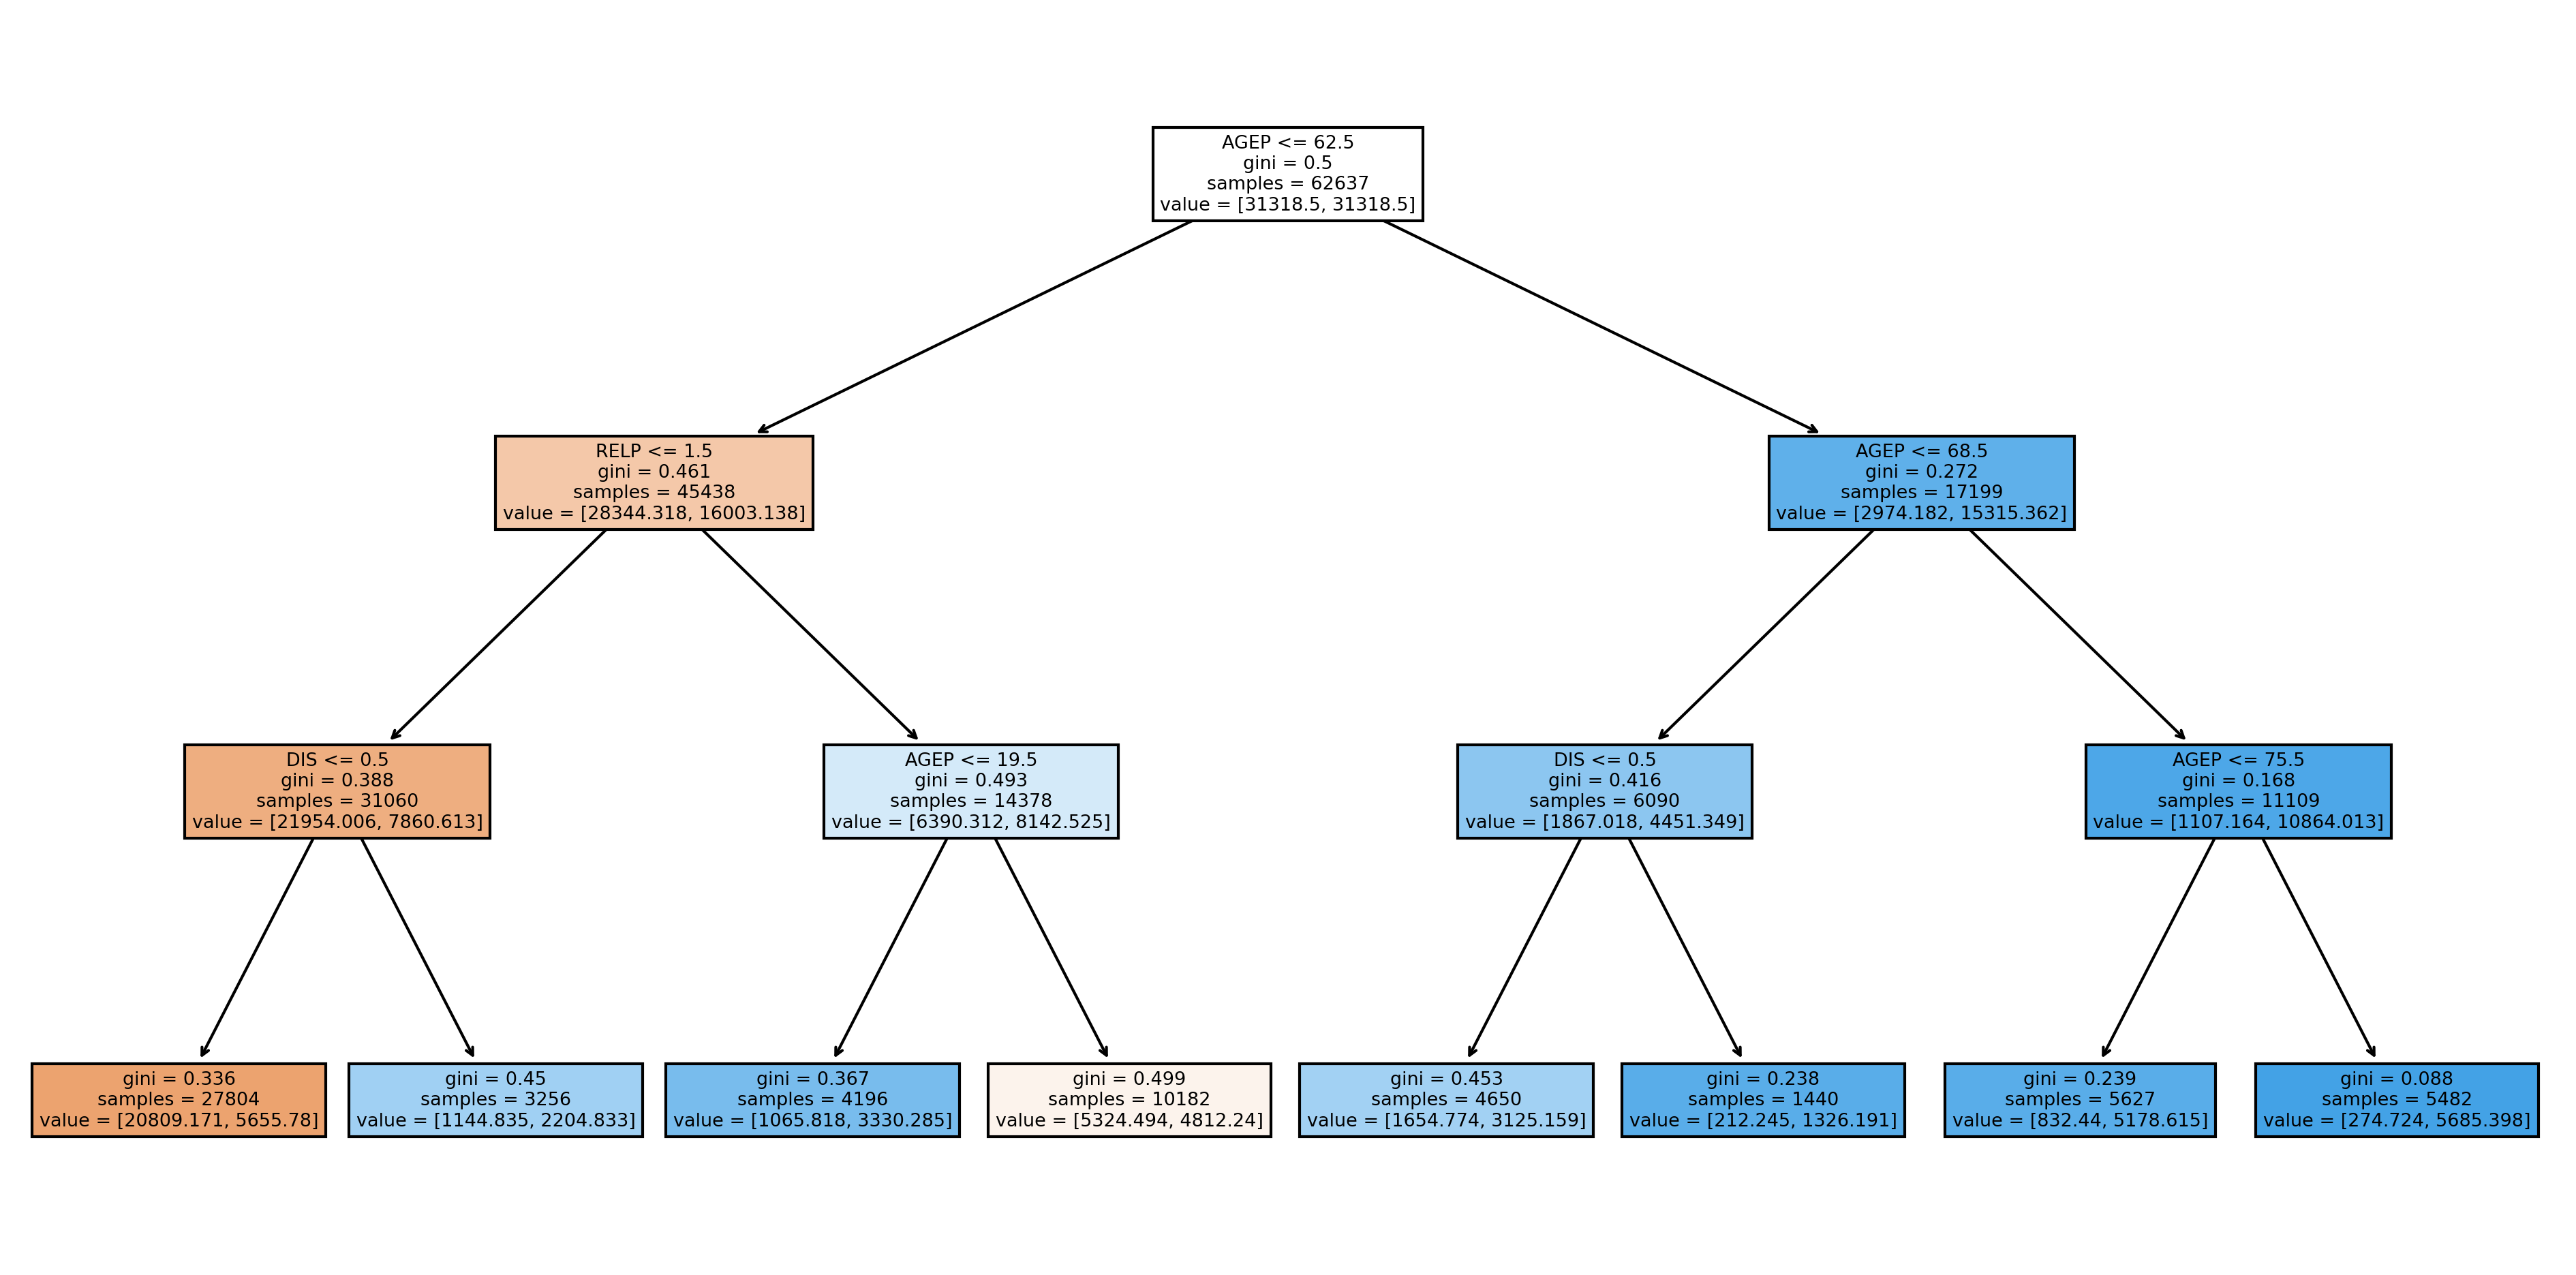

In [19]:
%matplotlib inline
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (16,8), dpi=300)
tree.plot_tree(class_models['decision_tree']['model'], feature_names=feature_l,\
               filled=True, max_depth=3)
fig.show()

As you can see, each node has a **gini coefficient**. It can use this to tally the importances of each feature:

In [20]:
dt_imp_df = pd.DataFrame({'feature':feature_l,\
                        'importance': class_models['decision_tree']['model'].feature_importances_})
dt_imp_df.sort_values(by='importance', ascending=False).style.\
            set_properties(**{'font-size': '13pt'}).set_table_styles(set_header_font())

It shouldn't surprise you that only three features have importances because the three only uses three of the features!

#### 5.1.3) Fast interpretable greedy-tree sums (FIGS)

This is a new interpretable tree-based model, which is very promising.

![FIGS diagram](./FIGS_Figure1.png)

> Tan, Y.S., Singh, C., Nasseri, K., Agarwal, A., & Yu, B. (2022). Fast Interpretable Greedy-Tree Sums (FIGS). [ArXiv, abs/2201.11931](https://arxiv.org/abs/2201.11931).

It's more than one tree, and each tree adds to make the predictions:

In [21]:
figs_mdl = class_models['figs']['model']
print(figs_mdl.__str__())

> ------------------------------
> FIGS-Fast Interpretable Greedy-Tree Sums:
> 	Predictions are made by summing the "Val" reached by traversing each tree
> ------------------------------
AGEP <= 62.500 (Tree #0 root)
	RELP <= 1.500 (split)
		SEX <= 1.500 (split)
			Val: 0.177 (leaf)
			Val: 0.315 (leaf)
		AGEP <= 19.500 (split)
			Val: 0.753 (leaf)
			RELP <= 15.500 (split)
				Val: 0.366 (leaf)
				MIL <= 1.500 (split)
					Val: -0.003 (leaf)
					Val: 0.740 (leaf)
	AGEP <= 68.500 (split)
		Val: 0.692 (leaf)
		Val: 0.880 (leaf)

	+
DIS <= 0.500 (Tree #1 root)
	Val: -0.048 (leaf)
	AGEP <= 62.500 (split)
		AGEP <= 34.500 (split)
			Val: 0.144 (leaf)
			Val: 0.376 (leaf)
		Val: 0.112 (leaf)

	+
SCHL <= 19.500 (Tree #2 root)
	Val: 0.023 (leaf)
	Val: -0.070 (leaf)



This can be easily read by splitting on feature values on every branch. You can even extract "rules" from traversing every tree till each leave and then the models' rules are the cardinal product of every trees' rules.

#### 5.1.4) RuleFit

RuleFit extracts rules from a Gradient Boosted Decision Tree and converts them into a binary feature.

It, then, fits a regularized logistic regression model to the rules (and optionally) the original features themselves.

> Friedman, J.H., & Popescu, B.E. (2008). PREDICTIVE LEARNING VIA RULE ENSEMBLES. The Annals of Applied Statistics, 2, 916-954. [arXiv:0811.1679](https://arxiv.org/abs/0811.1679)

You can extract the RuleFit rules, coefficients and intercept like this:

In [22]:
rulefit_mdl = class_models['rulefit']['model']

print('# Rules:\t%s' % len(rulefit_mdl.rule_ensemble.rules))
print('# Coefficients:\t%s' % len(rulefit_mdl.coef_))
print('Intercept:\t%.3f' % (rulefit_mdl.intercept_))

# Rules:	13
# Coefficients:	29
Intercept:	0.000


As you can see there are 29 coefficients but 13 rules. The difference is due to 16 coefficients belonging to the original features. You can also use the `get_rules` function to get a dataframe with all the model details:

In [23]:
rule_df = rulefit_mdl.get_rules()

Now let's display the dataframe without rules with a coeffcient of zero. Because RuleFit uses L1 regularization there are plenty of rules left out.

In [24]:
rule_df['support'] = rule_df['support'] * 100
rule_df['rule'] = rule_df.rule.str.replace(' & ',' &<br/>')

rule_df[rule_df.coef != 0].sort_values(["importance"], ascending=False).style.\
    format({'support':'{:.1f}%', 'importance':'{:.3f}'}).\
    bar(subset=['support'], color='#4EF', width=50).\
    set_properties(**{'font-size': '16pt'}).set_table_styles(set_header_font())

Support shows what percentage of the training dataset was supported by that rule.

#### 5.1.5) Explainable Boosting Machines

EBM leverages the Generalized Additive Models (GAM)s, which are like linear models but look like this:

$\large{\hat{y} = g(E[y]) = \beta_0 + f_1(x_1) + f_2(x_2) + \text{...} + f_j(x_j)}$

Individual functions $f_1$ through $f_p$ are fitted to each feature using spline functions. Then a link function $g$ adapts the GAM to perform different tasks such as classification or regression, or adjust predictions to different statistical distributions. 

EBM incorporates bagging and gradient boosting, which tend to make models more performant. The boosting is done one feature at a time using a low learning rate not to confound them. It also finds practical interaction terms automatically, which improves performance while maintaining interpretability:

$\large{\hat{y} = g(E[y]) = \beta_0 + \sum f_j(x_j) + \sum f_{ji}(x_j, x_i)}$

Once fitted, this formula is made up of complicated non-linear formulas, so a global holistic interpretation isn't likely feasible. However, since the effects of each feature or pairwise interaction terms are additive, they are easily separable, global modular interpretation is entirely possible. 

> Lou, Y., Caruana, R., Gehrke, J., & Hooker, G. (2013). Accurate intelligible models with pairwise interactions. Proceedings of the 19th ACM SIGKDD international conference on Knowledge discovery and data mining. [DOI:10.1145/2487575.2487579](https://dl.acm.org/doi/10.1145/2487575.2487579)

In [25]:
ebm_mdl = class_models['ebm']['model']

show(ebm_mdl.explain_global())

interpret.visual.udash:INFO: Generated mini dash


<!-- http://127.0.0.1:7001/5626604880/ -->

So what to do with **Random Forest**, **Catboost**, and **MLP**?

### 5.2) Model-agnostic (treats the model as a "black box")
#### _also known as post-hoc interpretability_

#### 5.2.1) Global Explanations with SHAP

Creating a SHAP explainer is simple:

In [26]:
%%time
cb_mdl = class_models['catboost']['model']
cb_explainer = shap.Explainer(cb_mdl)
cb_shap = cb_explainer(X_test)

CPU times: user 2.12 s, sys: 220 ms, total: 2.34 s
Wall time: 3.38 s


We can verify it's the right explainer like this:

In [27]:
print(type(cb_explainer))

<class 'shap.explainers._tree.Tree'>


> **IMPORTANT NOTE**: Tree SHAP explainers are technically not model-agnostic but the SHAP library includes methods for most models, including some model-agnostic ones like Kernel Explainer.

We can do the same with MLP except since it uses the Kernel Explainer it takes much longer: 

In [28]:
%%time
mlp_mdl = class_models['mlp']['model']
mlp_explainer = shap.KernelExplainer(mlp_mdl.predict, shap.kmeans(X_train, 20))

#takes long
# mlp_shap_vals = mlp_explainer.shap_values(X_test.sample(frac=.05))

CPU times: user 9.21 s, sys: 1.41 s, total: 10.6 s
Wall time: 1.94 s


In [29]:
print(type(mlp_explainer))

<class 'shap.explainers._kernel.Kernel'>


In any case, the SHAP object will return data and values of equal dimensions:

In [30]:
print("Values dimensions: %s" % (cb_shap.values.shape,)) 
print("Data dimensions:   %s" % (cb_shap.data.shape,))

Values dimensions: (20880, 16)
Data dimensions:   (20880, 16)


one SHAP value per each feature-observation datapoint.

So, what can we do with SHAP? For starters...

**Bar chart with feature importance**

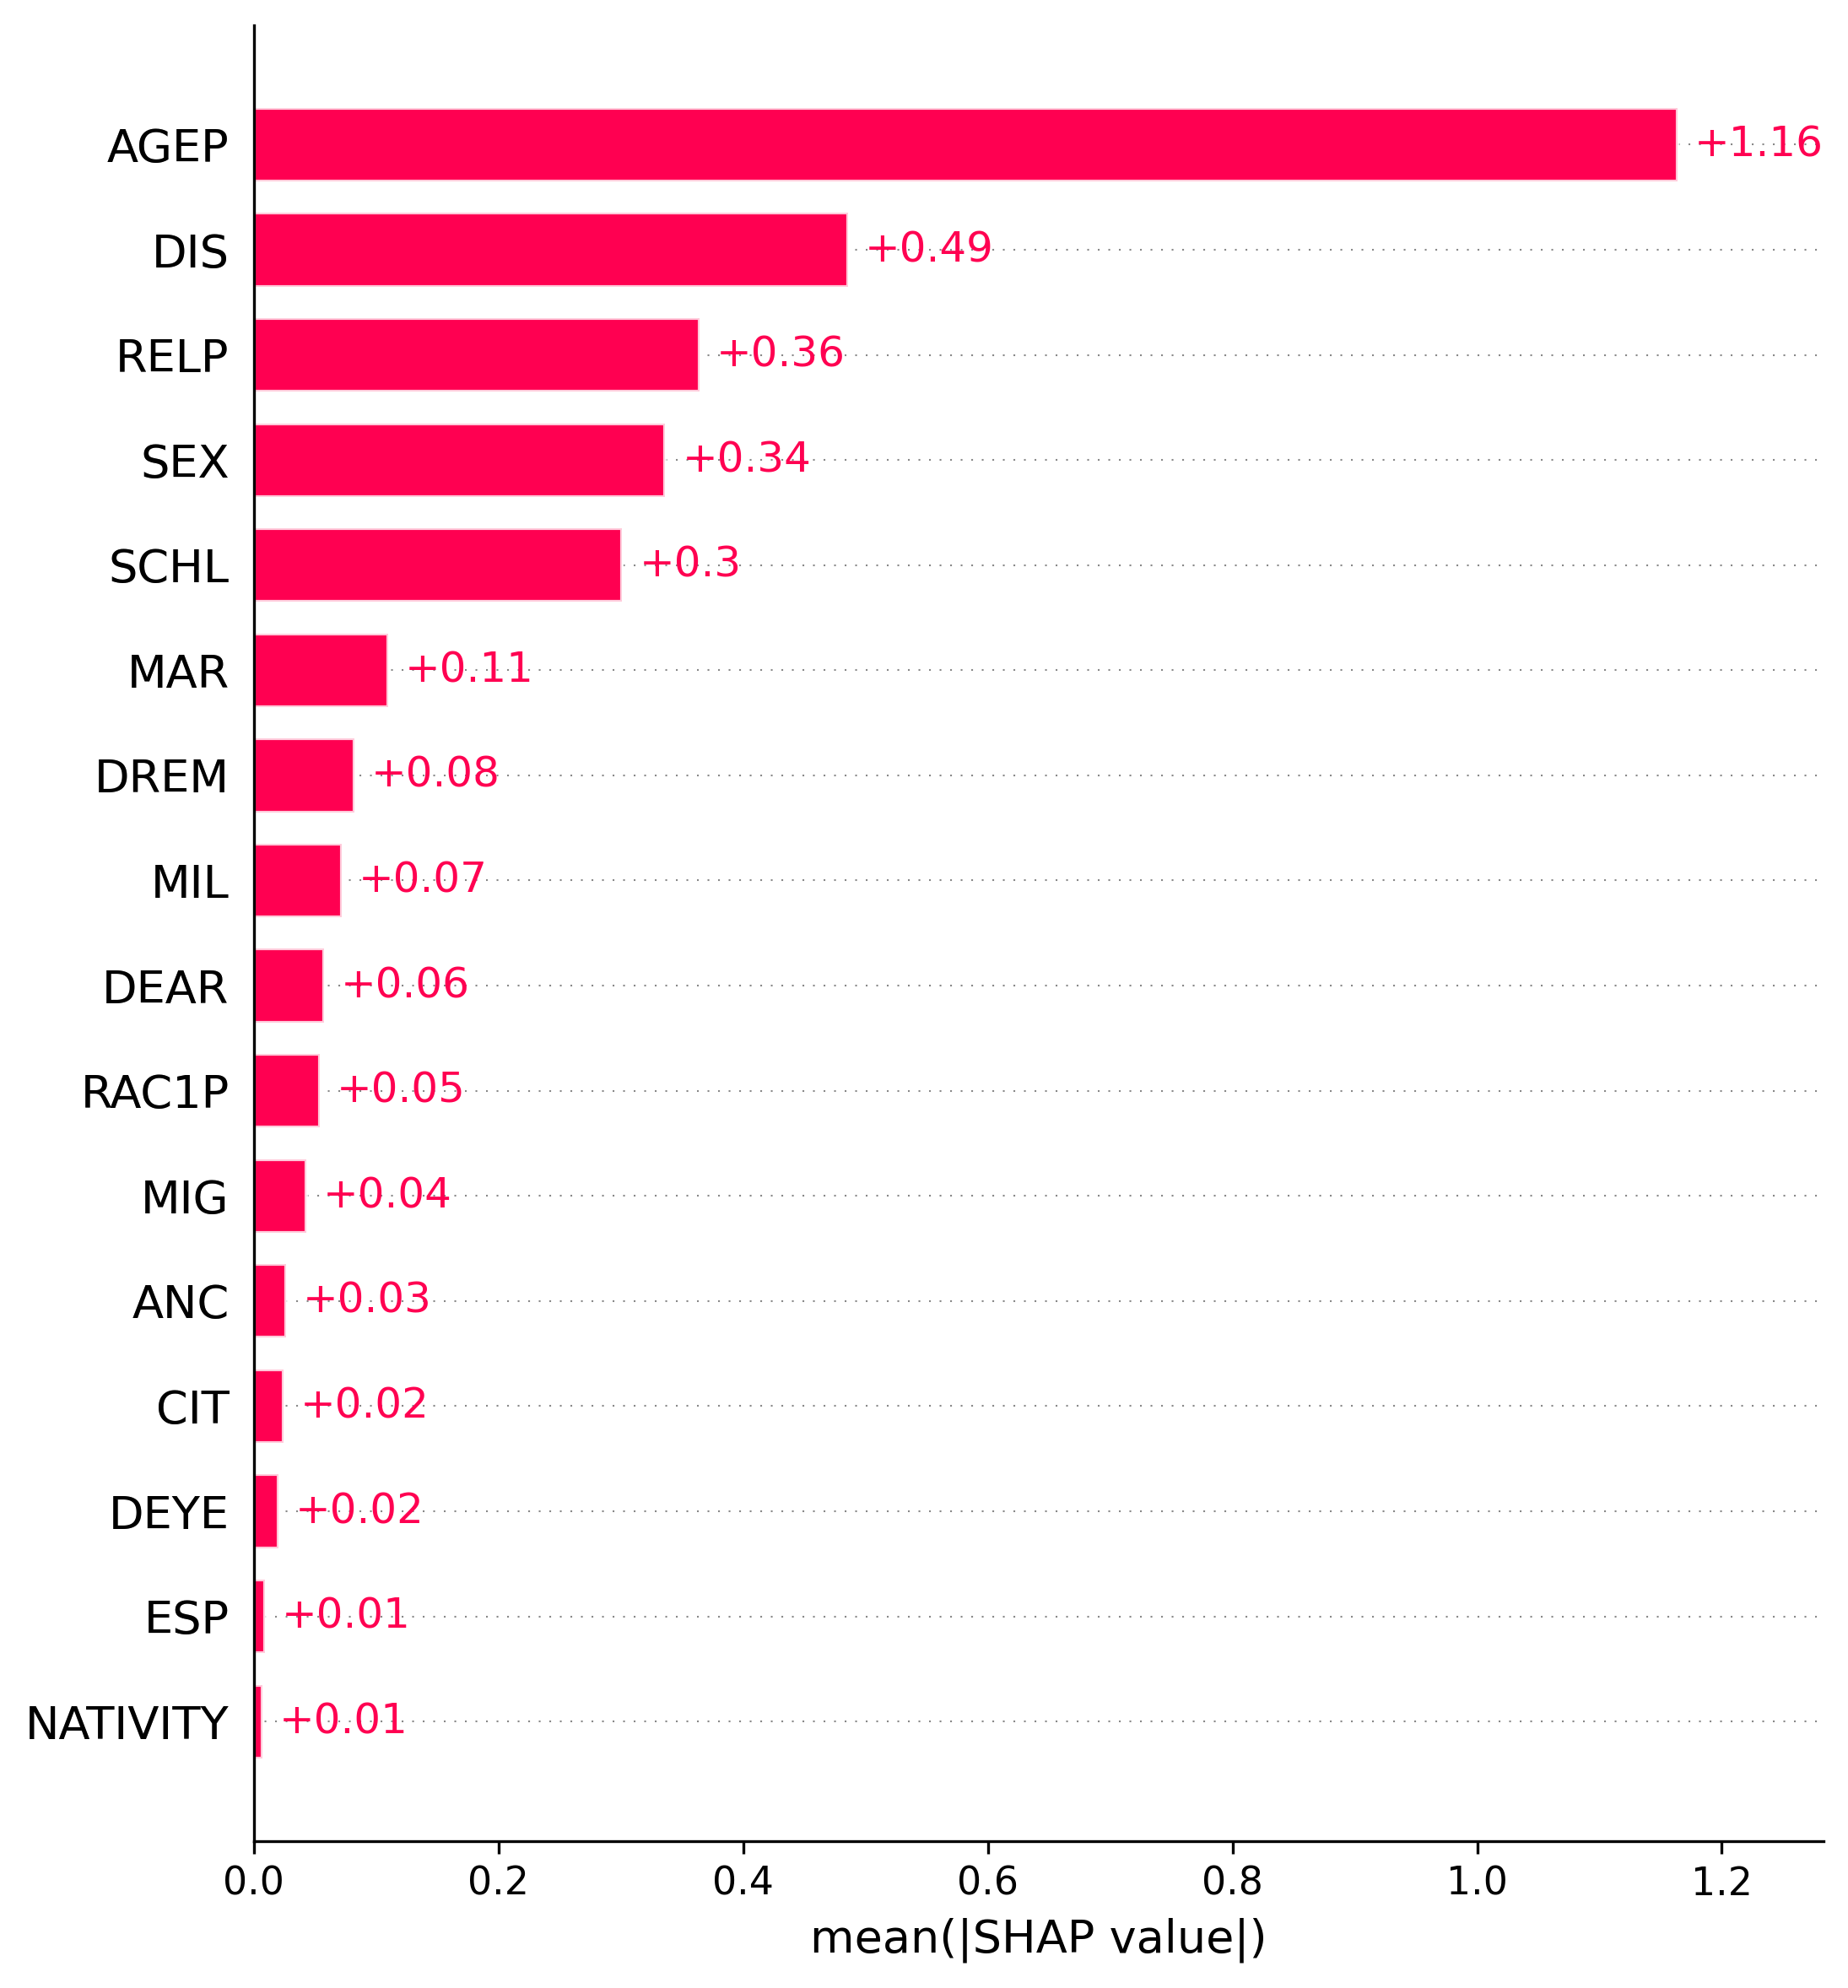

In [31]:
plt.figure(figsize=(12, 12), dpi=300)
shap.plots.bar(cb_shap, max_display=17, show=False)
plt.show()

**Bar chart with feature importance (split by cohorts)**

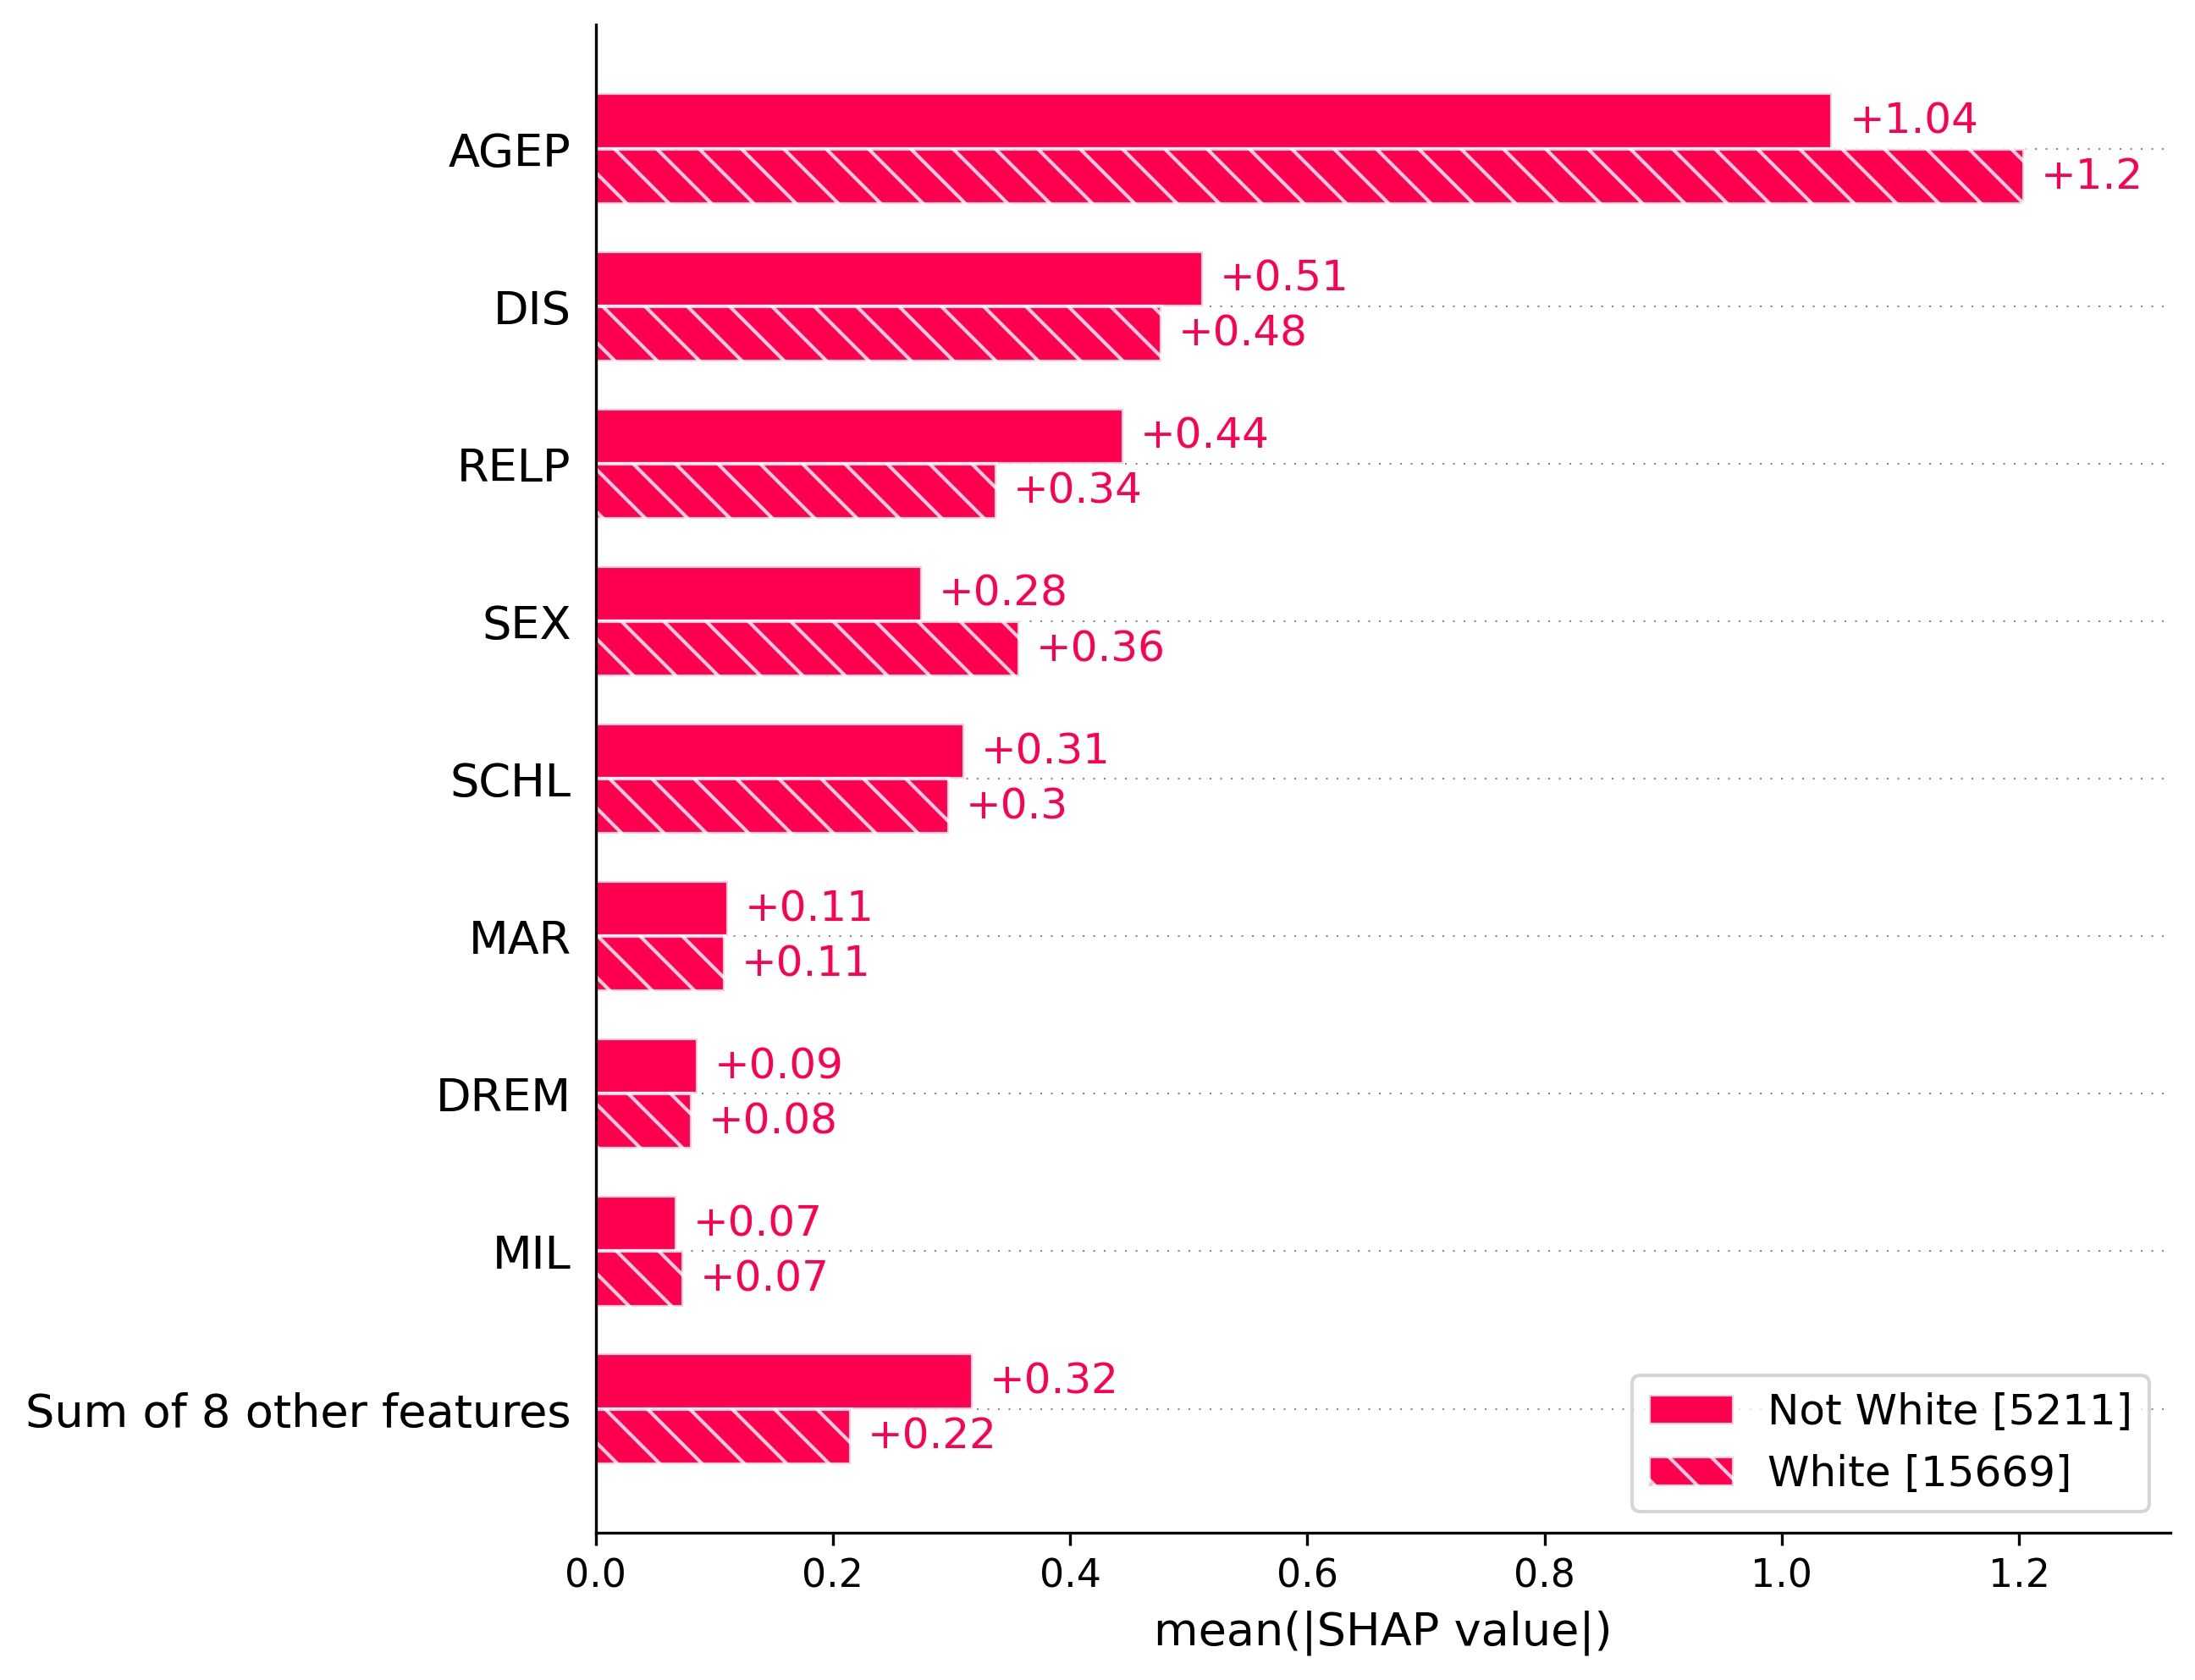

In [32]:
plt.figure(figsize=(12, 12), dpi=300)
race_cohort = np.where(X_test.RAC1P == 1, "White", "Not White")
shap.plots.bar(cb_shap.cohorts(race_cohort).abs.mean(0), max_display=9,\
               show=False)
plt.show()

**Beeswarm plot**

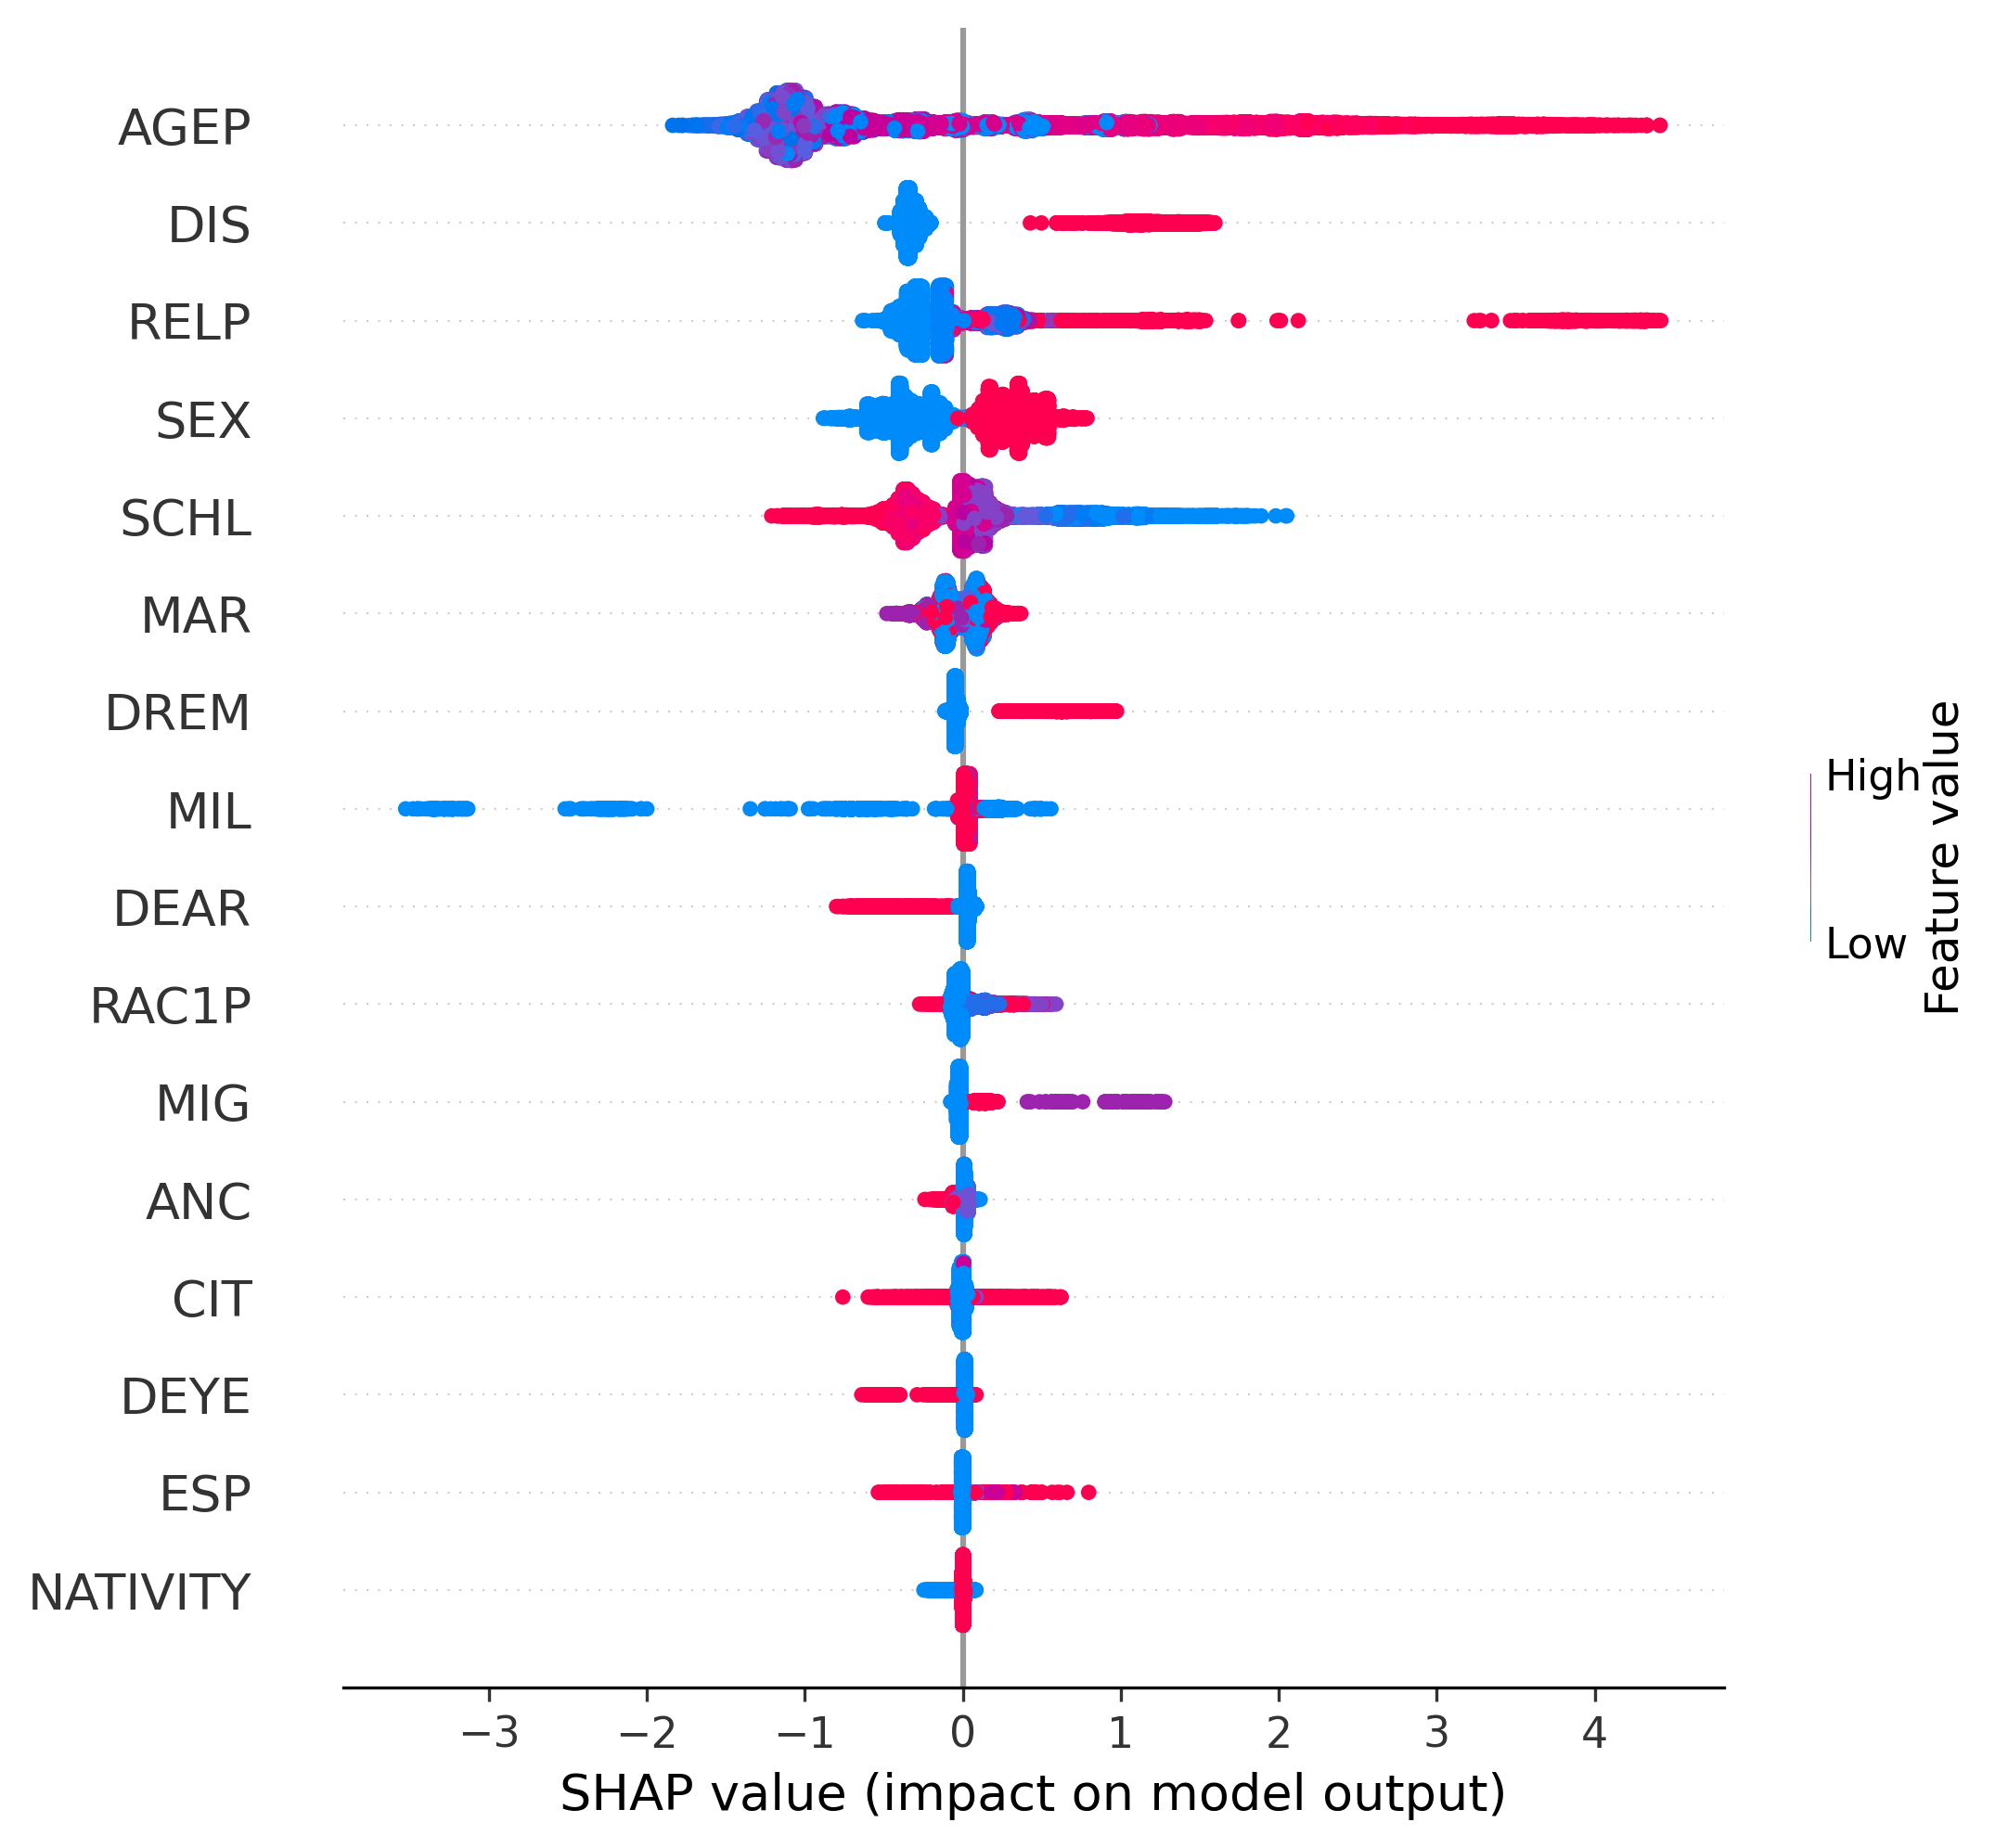

In [33]:
plt.figure(figsize=(12, 12), dpi=300)
shap.plots.beeswarm(cb_shap, max_display=17, show=False)
plt.show()

#### 5.2.2) Feature Summary Explanations

**Partial dependence plots**

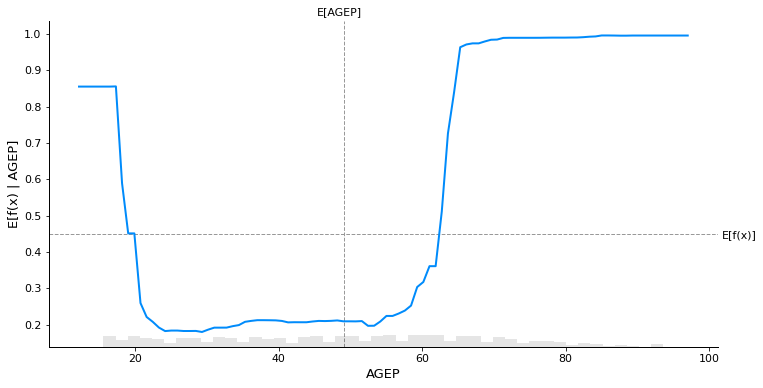

In [34]:
plt.rcParams["figure.figsize"] = (12,6)
shap.plots.partial_dependence("AGEP", cb_mdl.predict, X_test,\
                              ice=False, model_expected_value=True, feature_expected_value=True,\
                              show=False)
plt.show()

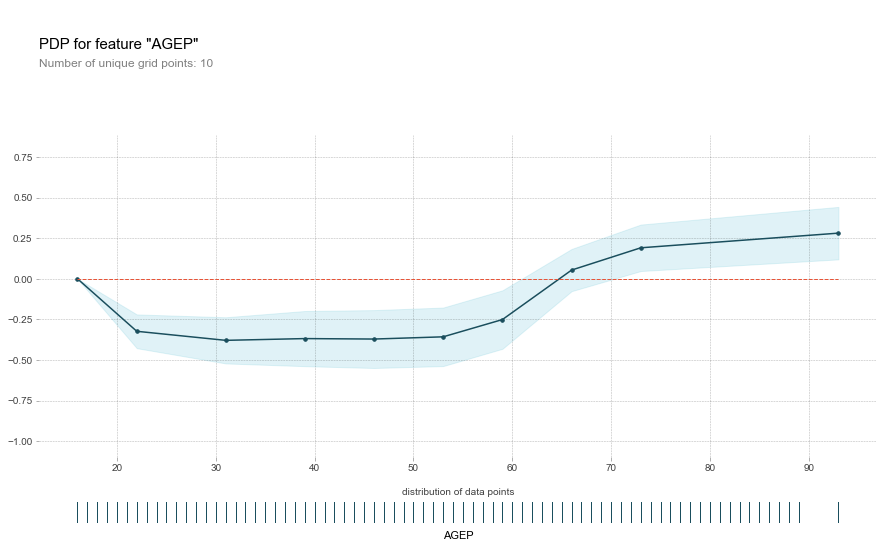

In [35]:
pdp_single_feature = pdp.pdp_isolate(
    model=cb_mdl, dataset=X_test, model_features=feature_l, feature='AGEP'
)
fig, axes = pdp.pdp_plot(pdp_single_feature, 'AGEP', plot_pts_dist=True)
plt.show()

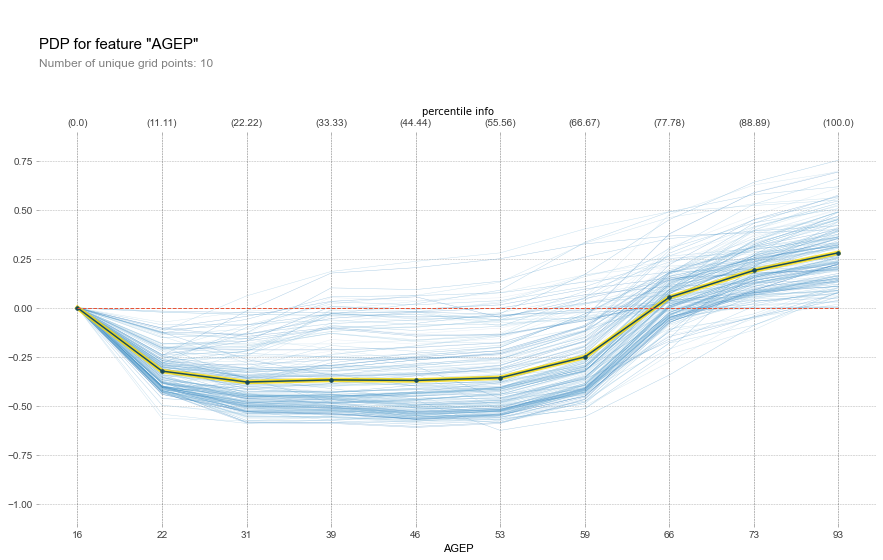

In [36]:
fig, axes = pdp.pdp_plot(
    pdp_single_feature, 'AGEP', plot_lines=True, frac_to_plot=0.01,\
    x_quantile=True, show_percentile=True
)
plt.show()

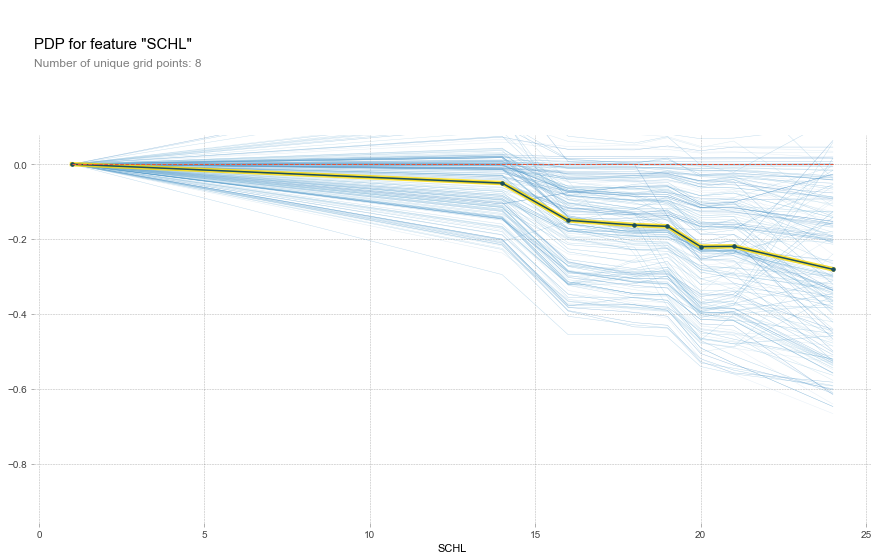

In [37]:
pdp_single_feature = pdp.pdp_isolate(
    model=cb_mdl, dataset=X_test, model_features=feature_l, feature='SCHL'
)
fig, axes = pdp.pdp_plot(
    pdp_single_feature, 'SCHL', plot_lines=True, frac_to_plot=0.01
)
plt.show()

**ALE plot**

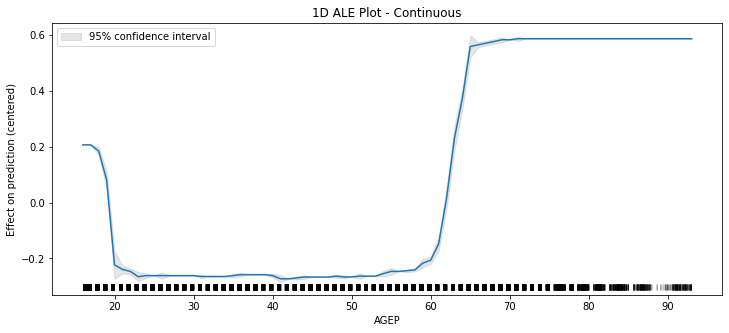

In [38]:
ale_effect = ale(X=X_test, model=cb_mdl, feature=['AGEP'], feature_type='continuous',\
                 grid_size=80) 
plt.gcf().set_size_inches(12, 5)
plt.gca().ticklabel_format(useOffset=False, style='plain')
plt.show()

**SHAP scatter plot**

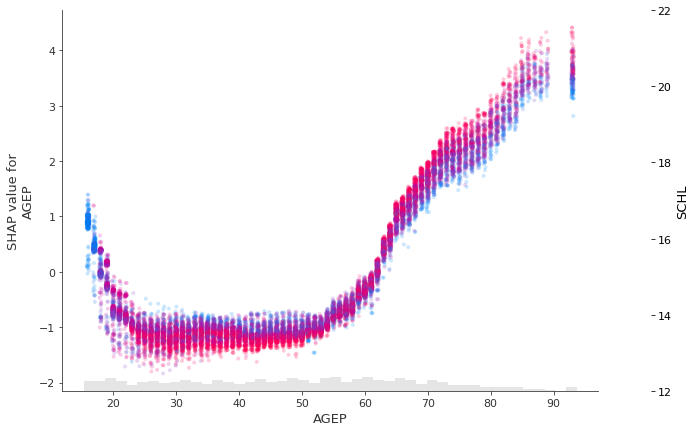

In [39]:
shap.plots.scatter(cb_shap[:,"AGEP"], color=cb_shap[:,"SCHL"],\
                   show=False, alpha=0.2, x_jitter=0.4)
plt.gcf().set_size_inches(12, 7)
plt.show()

#### 5.2.3) Feature Interactions

**Clustered bar chart**

17it [00:19,  1.92s/it]                        


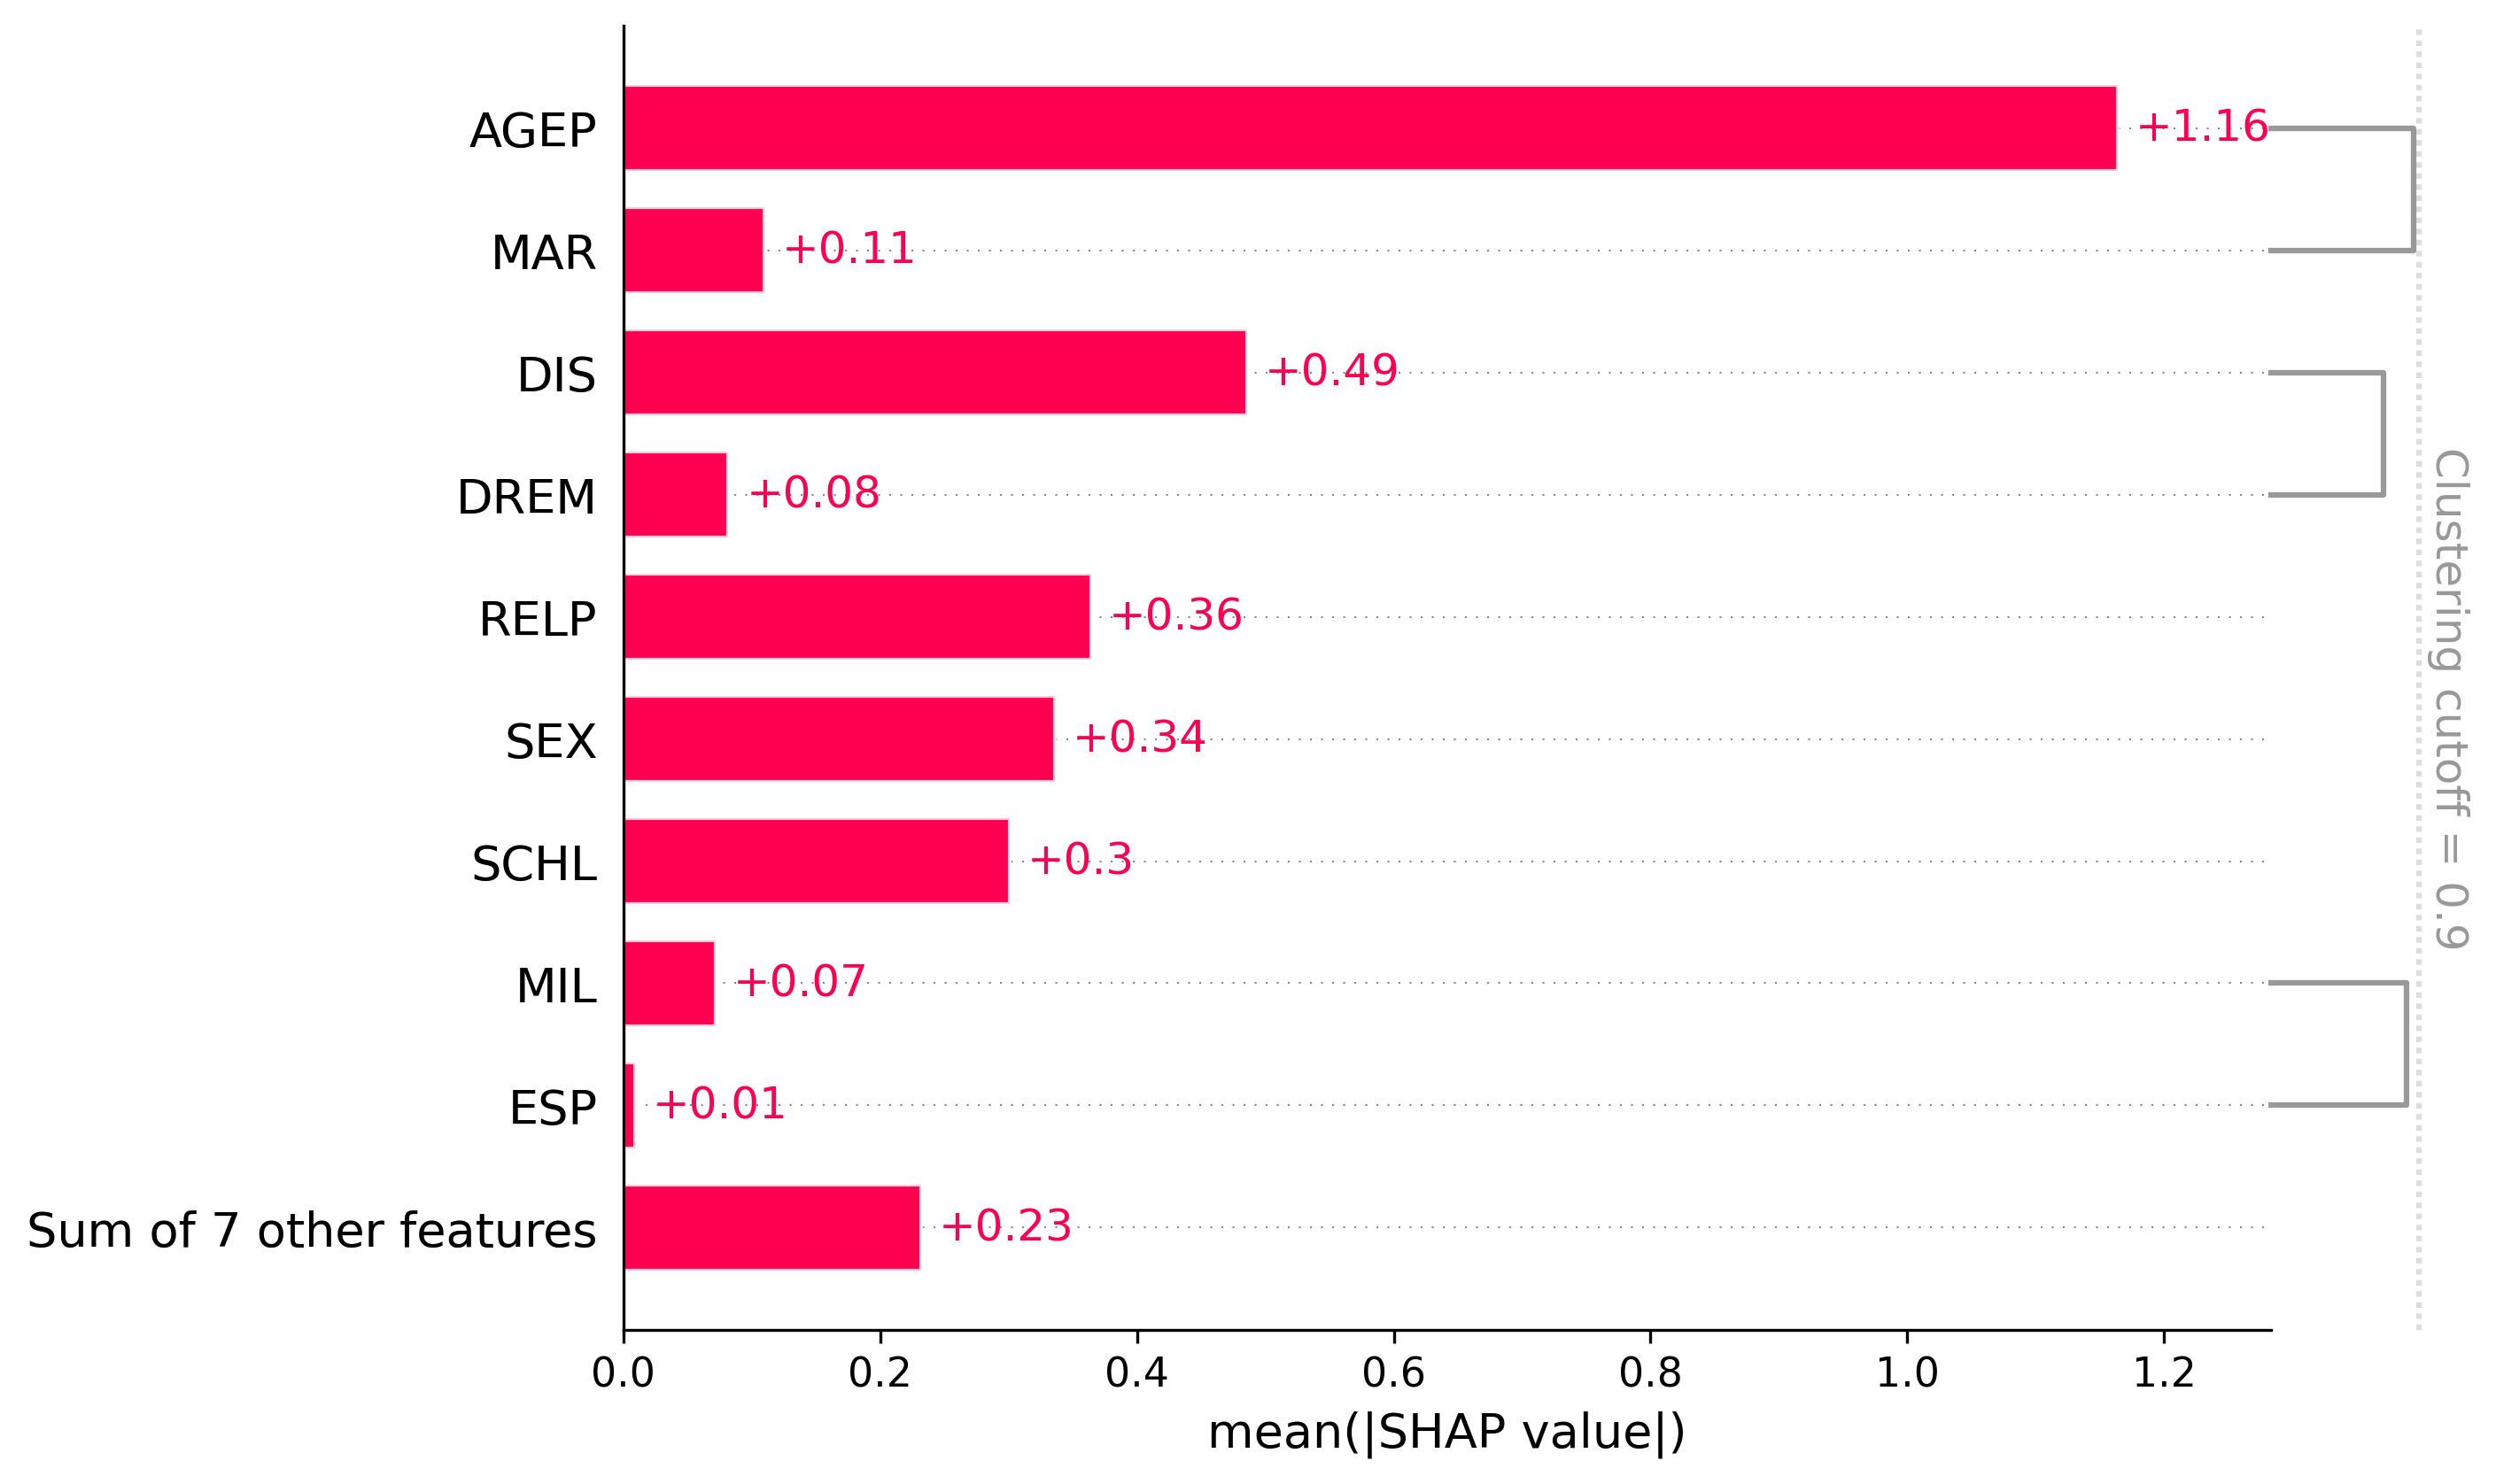

In [40]:
plt.figure(figsize=(12, 12), dpi=300)
clustering = shap.utils.hclust(X, y)
shap.plots.bar(cb_shap, clustering=clustering, clustering_cutoff=0.9,\
               show=False)
plt.show()

**ALE 2D plot**

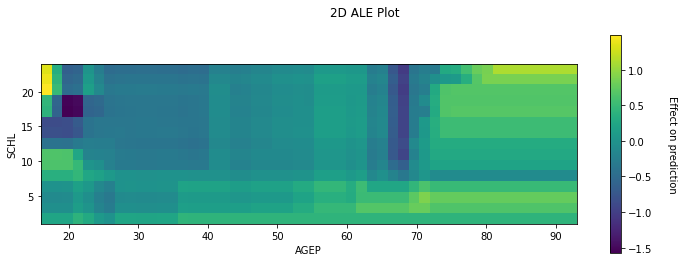

In [41]:
features_l = ["SCHL", "AGEP"]
ale_effect = ale(X=X_test, model=cb_mdl, feature=features_l, feature_type='continuous',\
                 grid_size=50) 
plt.gcf().set_size_inches(12, 4) 
plt.gca().ticklabel_format(useOffset=False, style='plain')
plt.show()

**PDP 2D plot**

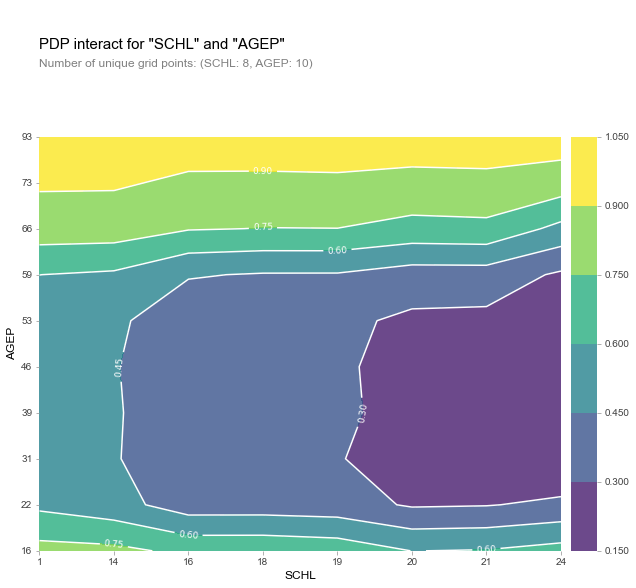

In [42]:
pdp_interaction_feature = pdp.pdp_interact(
    model=cb_mdl, dataset=X_test, model_features=X_test.columns, features=features_l
)
fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out=pdp_interaction_feature, feature_names=features_l, plot_type='contour', x_quantile=True,\
    figsize=(10,10), plot_pdp=False)
plt.show()

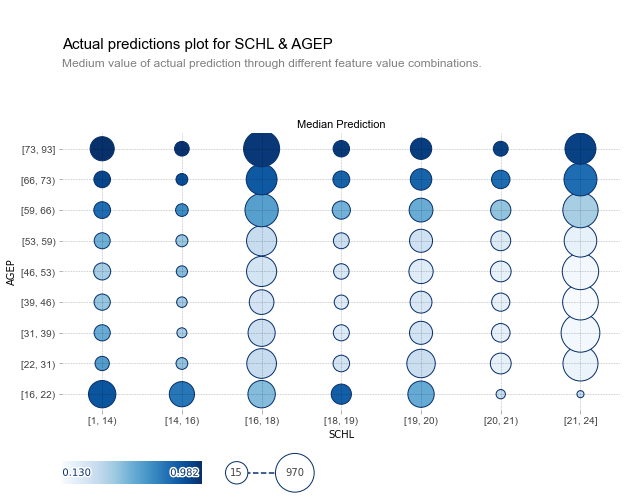

In [43]:
fig, axes, summary_df = info_plots.actual_plot_interact(
    model=cb_mdl, X=X_test, features=features_l, feature_names=features_l,\
    figsize=(10,9))
plt.show()

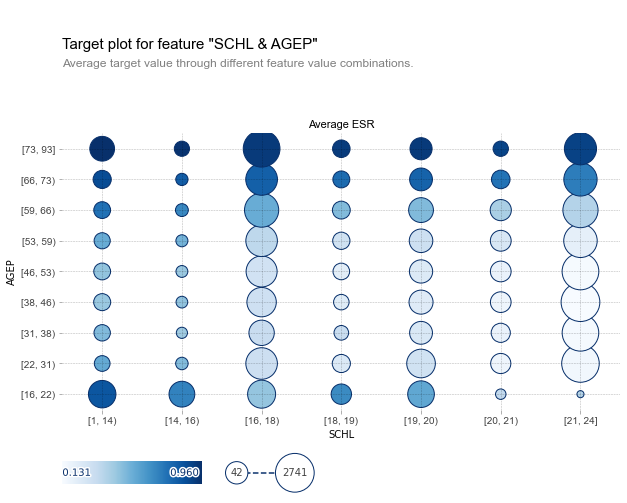

In [44]:
fig, axes, summary_df = info_plots.target_plot_interact(
    df=X_train.join(y_train), target='ESR', features=features_l, feature_names=features_l,\
    figsize=(10,9))
plt.show()

#### 5.2.4) Local Explanations

**Local Interpretable Model-agnostic explanations (LIME)**

In [45]:
cb_lime = LimeTabularExplainer(X_train.values, mode="classification", class_names=class_l,\
                               feature_names=X_train.columns.tolist(), kernel_width=1, verbose=True)

In [46]:
i = 20875
print("Observed:  %s" % class_l[y_test.iloc[i]])
cb_lime_exp = cb_lime.explain_instance(X_test.iloc[i].values, cb_mdl.predict_proba)
cb_lime_exp.show_in_notebook()

Observed:  Not Working
Intercept 0.48531068443513026
Prediction_local [0.68137499]
Right: 0.9473192793527526


In [47]:
i = 28
print("Observed:  %s" % class_l[y_test.iloc[i]])
cb_lime_exp = cb_lime.explain_instance(X_test.iloc[i].values, cb_mdl.predict_proba)
cb_lime_exp.show_in_notebook()

Observed:  Working
Intercept 0.2500437230838791
Prediction_local [1.05188672]
Right: 0.9927882588240411


**SHAP Bar plot**

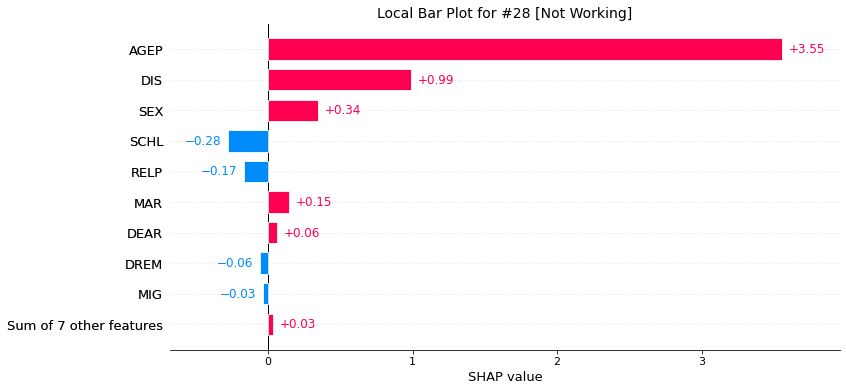

In [48]:
shap.plots.bar(cb_shap[28], show=False)
plt.gcf().set_size_inches(12, 6)
plt.title('Local Bar Plot for #28 [Not Working]', fontsize=14)
plt.show()

**SHAP waterfall plot**

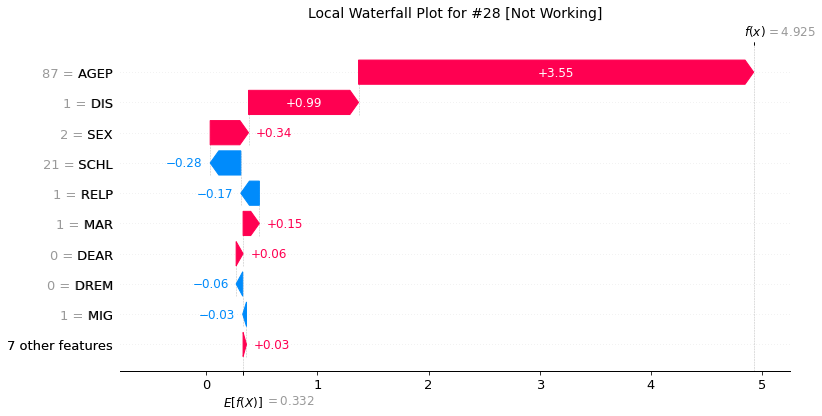

In [49]:
shap.plots.waterfall(cb_shap[28], show=False)
plt.gcf().set_size_inches(12, 6)
plt.title('Local Waterfall Plot for #28 [Not Working]', fontsize=14)
plt.show()

**SHAP force plot**

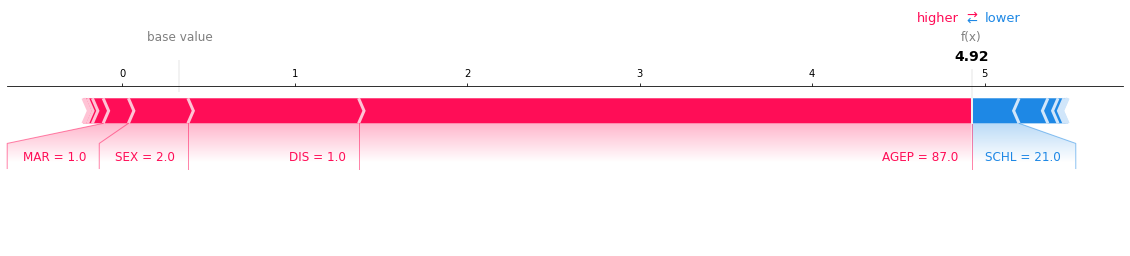

In [50]:
shap.plots.force(cb_shap[28], matplotlib=True)

**SHAP decision plots**

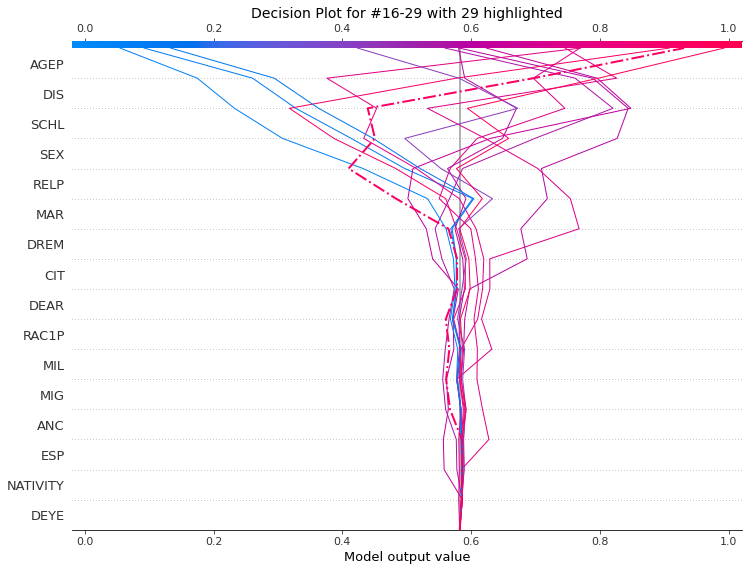

In [51]:
shap.decision_plot(cb_explainer.expected_value, cb_shap.values[16:30], X_test.iloc[16:30], highlight=13,\
                   show=False, link='logit')
plt.gcf().set_size_inches(12, 9)
plt.title('Decision Plot for #16-29 with 29 highlighted', fontsize=14)
plt.show()

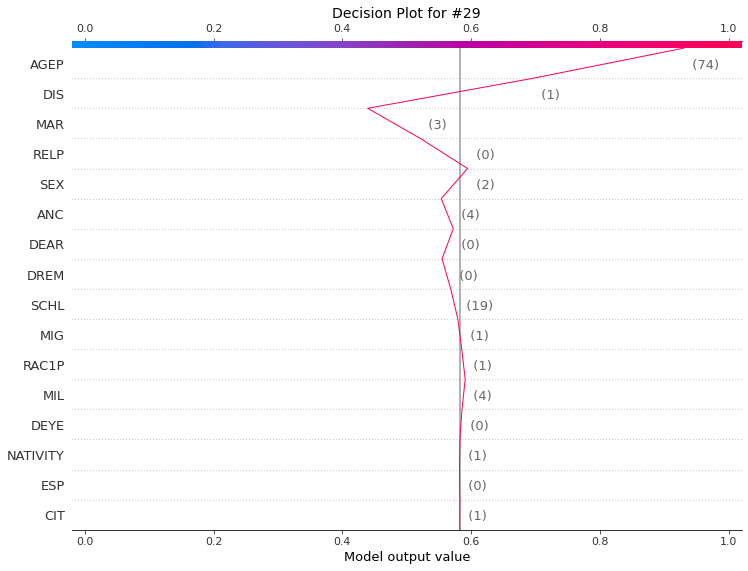

In [52]:
shap.decision_plot(cb_explainer.expected_value, cb_shap.values[29], X_test.iloc[29],\
                   show=False, link='logit')
plt.gcf().set_size_inches(12, 9)
plt.title('Decision Plot for #29', fontsize=14)
plt.show()